In [78]:
import numpy as np
from PIL import Image
from IPython.display import display

In [79]:
# define Fourier Transform
def ft_2d_iter(_image, k, l):
    res = 0
    N = _image.shape[0]
    for i in range(_image.shape[0]):
        for j in range(_image.shape[1]):
            res += _image[i, j] * np.e**(-2j * np.pi * ((k * i / N) + (l * j / N)))
    return res


def ft_2d(_image):
    F = []
    N = _image.shape[0]
    for k in range(N):
        F.append([])
        for l in range(N):
            F[k].append(ft_2d_iter(_image, k, l))
    return np.array(F)


def ftshift(F):
    N, M = F.shape
    shifted = np.zeros_like(F)
    
    shifted[N//2:, M//2:] = F[:N//2, :M//2]
    shifted[:N//2, :M//2] = F[N//2:, M//2:]
    shifted[N//2:, :M//2] = F[:N//2, M//2:]
    shifted[:N//2, M//2:] = F[N//2:, :M//2]
    return shifted

In [80]:
# Scale to see something
def scale_log_ft(arr):
    R = np.max(arr)
    c = 255 / np.log10(1 + R)
    print(f'{R=}\t{c=}')
    return c * np.log10(1.0 + arr)

def scale_linear_ft(arr):
    # Simple min-max normalization to 0-255 range
    return 255 * (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

In [100]:
# Inverse and unscale
def ift_2d_iter(_F, k, l):
    res = 0
    N = _F.shape[0]
    for i in range(N):
        for j in range(N):
            res += _F[i, j] * np.e**(2j * np.pi * ((i * k / N) + (j * l / N)))
    return res / (N * N)  # Don't forget normalization factor 1/N^2


def ift_2d(_F):
    result = []
    N = _F.shape[0]
    for k in range(N):
        result.append([])
        for l in range(N):
            result[k].append(ift_2d_iter(_F, k, l))
    return np.array(result)


def unscale_ft(arr, R):
    """Reverse the logarithmic scaling"""
    c = 255 / np.log(1 + R)
    return np.exp(arr / c) - 1.0

def inverse_ftshift(F):
    """Reverse the fftshift operation"""
    N, M = F.shape
    unshifted = np.zeros_like(F)
    
    unshifted[:N//2, :M//2] = F[N//2:, M//2:]
    unshifted[N//2:, M//2:] = F[:N//2, :M//2]
    unshifted[:N//2, M//2:] = F[N//2:, :M//2]
    unshifted[N//2:, :M//2] = F[:N//2, M//2:]
    return unshifted

In [151]:
def apply_window(image):
    # Create 2D Hanning window
    h, w = image.shape
    window = np.outer(np.hanning(h), np.hanning(w))
    
    # Apply window
    return image * window

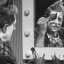

In [166]:
image_path = "../images/real.png" # will not work for non-squared image
image = Image.open(image_path).convert('L') # convert to gray-scale
image_array = np.array(image) / 255.0 # normalize image
display(Image.fromarray((image_array * 255.0).astype(np.uint8)))

In [153]:
# Apply ft and compare
my_ft = ft_2d(image_array)
np_fft = np.fft.fft2(image_array)

is_ft_close = np.allclose(my_ft, np_fft)
print(f'{is_ft_close=}')

is_ft_close=True


In [154]:
# Shift ft and compare
my_ft_shifted = ftshift(my_ft)
np_fft2_shifted = np.fft.fftshift(np_fft)

is_shift_close = np.allclose(my_ft_shifted, np_fft2_shifted)
print(f'{is_shift_close=}')

is_shift_close=True


In [155]:
# Split complex numbers in FT into 2: magnitude (v length) and angle w.r.t. the origin
magnitude_spectrum = np.abs(my_ft_shifted)
phase_spectrum = np.pi + np.angle(my_ft_shifted)

In [156]:
magnitude_spectrum_unshifted = np.abs(my_ft)
phase_spectrum_unshifted = np.pi + np.angle(my_ft)

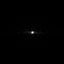

In [157]:
display(Image.fromarray(scale_linear_ft(magnitude_spectrum).astype(np.uint8)))

R=np.float64(544.4677937911086)	c=np.float64(93.17556192125566)


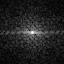

In [158]:
display(Image.fromarray(scale_log_ft(magnitude_spectrum).astype(np.uint8), mode='L'))

R=np.float64(6.283185307176993)	c=np.float64(295.713421763405)


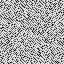

In [159]:
display(Image.fromarray(scale_log_ft(phase_spectrum).astype(np.uint8), mode='L'))

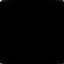

In [160]:
display(Image.fromarray(scale_linear_ft(magnitude_spectrum_unshifted).astype(np.uint8)))

R=np.float64(544.4677937911086)	c=np.float64(93.17556192125566)


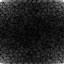

In [161]:
display(Image.fromarray(scale_log_ft(magnitude_spectrum_unshifted).astype(np.uint8), mode='L'))

R=np.float64(6.283185307176993)	c=np.float64(295.713421763405)


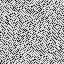

In [162]:
display(Image.fromarray(scale_log_ft(phase_spectrum_unshifted).astype(np.uint8), mode='L'))

In [163]:
original_R = np.max(np.abs(magnitude_spectrum))
scaled_magnitude = scale_log_ft(magnitude_spectrum)

unscaled_magnitude = unscale_ft(scaled_magnitude, original_R)
is_unscaled_close = np.allclose(np.abs(np_fft2_shifted), unscaled_magnitude)

unshifted_magnitude = inverse_ftshift(unscaled_magnitude)
is_unshifted_close = np.allclose(np.abs(np_fft), unshifted_magnitude)
print(f'{is_unscaled_close=}')
print(f'{is_unshifted_close=}')

R=np.float64(544.4677937911086)	c=np.float64(93.17556192125566)
is_unscaled_close=True
is_unshifted_close=True


In [164]:
np_ifft = np.fft.ifft2(np_fft)  # NumPy's inverse FFT for comparison

my_ift = ift_2d(my_ft)

# Check if our implementation matches NumPy's
print("Inverse FFT matches NumPy:", np.allclose(my_ift, np_ifft))


Inverse FFT matches NumPy: True


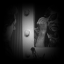

In [165]:
Image.fromarray(np.abs(my_ift * 255).astype(np.uint8))

In [167]:
# Digging deeper into FT and how and why it works

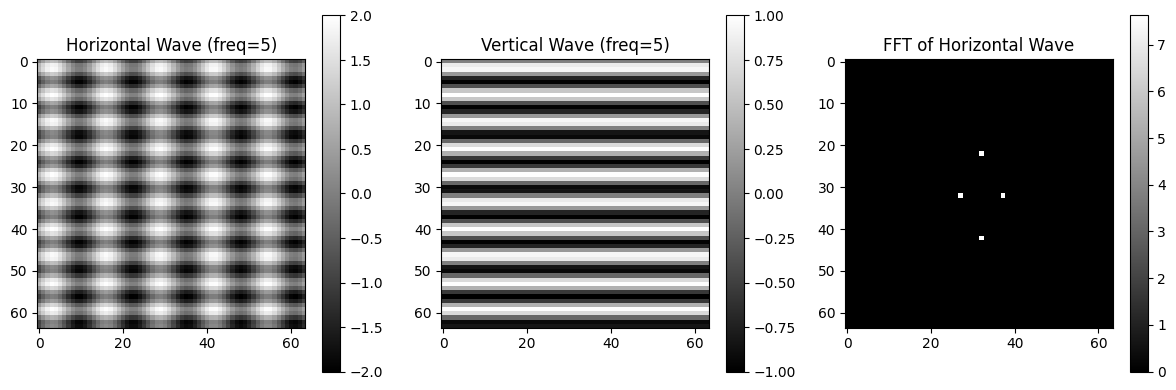

Image shape: (64, 64)
FFT shape: (64, 64)


In [188]:
import matplotlib.pyplot as plt

# Create a 64x64 image
size = 64

# Create coordinate arrays
x = np.arange(size)
y = np.arange(size)
X, Y = np.meshgrid(x, y)

# Create horizontal stripes with frequency 5
# This means 5 complete cycles across the image
horizontal_wave = np.sin(2 * np.pi * 5 * X / size)

# Create vertical stripes with frequency 5
vertical_wave = np.sin(2 * np.pi * 10 * Y / size)
horizontal_wave += vertical_wave

# Plot the images
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.imshow(horizontal_wave, cmap='gray')
plt.title('Horizontal Wave (freq=5)')
plt.colorbar()

plt.subplot(132)
plt.imshow(vertical_wave, cmap='gray')
plt.title('Vertical Wave (freq=5)')
plt.colorbar()

# Let's also show the FFT
fft_horizontal = np.fft.fft2(horizontal_wave)
fft_shifted = np.fft.fftshift(fft_horizontal)  # Center the zero frequency

plt.subplot(133)
plt.imshow(np.log(np.abs(fft_shifted) + 1), cmap='gray')
plt.title('FFT of Horizontal Wave')
plt.colorbar()

plt.tight_layout()
plt.show()

# Print the shape of the arrays for reference
print("Image shape:", horizontal_wave.shape)
print("FFT shape:", fft_horizontal.shape)